In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt, convert
from pyigrf12 import gridigrf12
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
from poes import dwnld_poes, get_aur_bnd, poes_plot_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
# import the sd-data overlay module
import os
import sys
module_path = os.path.abspath(os.path.join('../py/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import sd_scan_muh

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Some constants
eventDate = datetime.datetime(2015,4,9)
timeStart = datetime.datetime(2015,4,9,3,0)
timeEnd = datetime.datetime(2015,4,9,7,0)
sapsTime = datetime.datetime(2015,4,9,7,0)
velMagnScale = [ 0, 1000 ]
coords="mlt"
pltCoords = "mlt"
delLatDist = 111. * 1e3 # 1 deg lat is 111 km
cntrPotMin = -32.
cntrPotMax = 0.
cntrLevels = numpy.linspace(cntrPotMin, cntrPotMax, 9, endpoint=True)
# SD plot variables
sapsRadList = [ "cvw", "cve","fhw",\
               "fhe", "bks", "wal" ]#[ "cvw" ]
sddata_type = "raw_los" 
sapsMlatRange = [54,70]
velScale = [ -300, 300 ]

In [3]:
mapTime = sapsTime
ssusiDir = "../data/ssusi/"
poesRawDir = "../data/poes/raw/"
poesBndDir = "../data/poes/bnd/"
ssusiTime = sapsTime
vecsTime = sapsTime
inpDst = -5.#-116#-5.
inpAsy = 20#100#20.
sapsProbCutoff = 0.2

In [4]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

def get_geo_coords(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    currMlon = convert_mlt( currMLT, row["date"] , m2a=True )
    glat, glon = convert( row["mlat"], currMlon , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

def get_efield(row):
    Bx,By,Bz,Bf, yeardec = gridigrf12( row["date"], 0, 1, 300., row["glat"], row["glon"] )
    Vy = row["velSAPS"] * numpy.round( numpy.sin(numpy.deg2rad( row["azimSAPS"] )), 2 )
    Vx = row["velSAPS"] * numpy.round( numpy.cos(numpy.deg2rad( row["azimSAPS"] )), 2 )
    Vz = 0.
    Ex = Bz[0] * -1 * Vy * 1e-9 # nT
    Ey = Bz[0] * Vx * 1e-9 # nT
    Ez = Bx[0] * Vy * 1e-9 - By[0] * Vx * 1e-9 # nT
    # Round electric fields by 2
    Ex = numpy.round( Ex * 1e3 , 4 ) # mV/m
    Ey = numpy.round( Ey * 1e3 , 4 ) # mV/m
    Ez = numpy.round( Ez * 1e3 , 4 ) # mV/m
    return str(Ex) + "__" + str(Ey) + "__" + str(Ez)

In [5]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
# get only SAPS data
lshellDF = lshellDF[ (lshellDF["mlat"] >= sapsMlatRange[0]) &\
                   (lshellDF["mlat"] <= sapsMlatRange[1]) ]
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date
0,-5.843504,3.132609,0.5,1,59.0,0.0,140.541976,11.352182,59.01,-0.14,2015-04-09 06:00:00
1,-7.123473,2.457267,1.0,1,56.0,-2.0,78.321489,3.037617,56.01,-2.08,2015-04-09 06:00:00
3,-12.636368,2.601492,0.5,1,55.0,0.0,89.928598,2.651080,55.02,-0.09,2015-04-09 06:00:00
4,-1.039138,0.667806,1.5,1,57.0,2.0,122.262371,2.330879,57.00,1.88,2015-04-09 06:00:00
5,-16.008926,3.264575,0.5,1,54.5,0.0,89.961529,2.985215,54.52,-0.09,2015-04-09 06:00:00


In [6]:
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )

lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,-5.843504,3.132609,0.5,1,59.0,0.0,140.541976,11.352182,59.01,-0.14,2015-04-09 06:00:00,59.01,-0.14,-17.0,-19.0
1,-7.123473,2.457267,1.0,1,56.0,-2.0,78.321489,3.037617,56.01,-2.08,2015-04-09 06:00:00,56.01,-2.08,-47.0,-48.0
3,-12.636368,2.601492,0.5,1,55.0,0.0,89.928598,2.651080,55.02,-0.09,2015-04-09 06:00:00,55.02,-0.09,-17.0,-18.0
4,-1.039138,0.667806,1.5,1,57.0,2.0,122.262371,2.330879,57.00,1.88,2015-04-09 06:00:00,57.00,1.88,13.0,11.0
5,-16.008926,3.264575,0.5,1,54.5,0.0,89.961529,2.985215,54.52,-0.09,2015-04-09 06:00:00,54.52,-0.09,-17.0,-18.0


In [7]:
lshellDF["gcoord"] = lshellDF.apply( get_geo_coords, axis=1 )
lshellDF["glat"] = [ float( x.split("__")[0] ) for x in lshellDF["gcoord"] ]
lshellDF["glon"] = [ float( x.split("__")[1] ) for x in lshellDF["gcoord"] ]
lshellDF["Efield"] = lshellDF.apply( get_efield, axis=1 )
lshellDF["Ex"] = [ float( x.split("__")[0] ) for x in lshellDF["Efield"] ]
lshellDF["Ey"] = [ float( x.split("__")[1] ) for x in lshellDF["Efield"] ]
lshellDF["Ez"] = [ float( x.split("__")[2] ) for x in lshellDF["Efield"] ]
lshellDF["Efield"] = numpy.sqrt( numpy.square(lshellDF["Ex"]) +\
                                 numpy.square(lshellDF["Ey"]) +\
                                 numpy.square(lshellDF["Ez"]))

In [8]:
selTimeLshellDF = lshellDF[ lshellDF["date"] == sapsTime ]
mltVelsVarsDF = selTimeLshellDF[ ["normMlt", "mlat", "velSAPS", "Efield"] \
                    ].groupby( ["normMlt", "mlat"] ).mean().reset_index()

mltVelsVarsDF.columns = ["normMlt", "mlat", "mean_vel", "mean_efld"]
# stdVelsVarsDF = selTimeLshellDF[ ["normMlt", "mlat", "velSAPS", "Efield"] \
#                     ].groupby( ["normMlt", "mlat"] ).std().reset_index()
# stdVelsVarsDF.columns = ["normMlt", "mlat", "std_vel", "std_efld"]
# print stdVelsVarsDF
# mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMlt", "mlat"] )
mltVelsVarsDF = mltVelsVarsDF.dropna().reset_index(drop=True)
mltVelsVarsDF.head()

,normMlt,mlat,mean_vel,mean_efld
0,-3.0,62.5,424.747743,20.317759
1,-3.0,63.0,426.256889,20.440842
2,-2.0,61.5,273.070747,13.139065
3,-2.0,62.0,346.185391,16.672880
4,-2.0,62.5,387.925198,18.758684


In [9]:
# Arrays to store potential
potBinArr = []
potNrmMltArr = []
potmlatArr = []
potPotArr = []

for cmlt in mltVelsVarsDF["normMlt"].unique().tolist():
    # Get Uniq Lats at the MLT!
    selMltDF = mltVelsVarsDF[ mltVelsVarsDF["normMlt"] == cmlt ]
    # At each MLT we assume potential is zero at the lowest
    # latitude!
    prevPot = 0
    for cmlat in sorted( selMltDF["mlat"].unique().tolist() ):
        selLatsDF = selMltDF[ (selMltDF["mlat"] == cmlat) ]
        # Remember we have 0.5 deg latitude res
        # so we take delLatDist/2
        potLat = selLatsDF[ selLatsDF["mlat"] == cmlat ]["mean_efld"] * delLatDist/2. * 1e-3 * 1e-3 # kV
        currPot = prevPot - potLat.values[0]
        prevPot = currPot
        potNrmMltArr.append( cmlt )
        potmlatArr.append( cmlat )
        potPotArr.append( round(currPot,2) )
        
potentialDF = pandas.DataFrame({
            "normMlt" : potNrmMltArr,
            "mlat" : potmlatArr,
            "potential" : potPotArr
            })
potentialDF.head()

,mlat,normMlt,potential
0,62.5,-3.0,-1.13
1,63.0,-3.0,-2.26
2,61.5,-2.0,-0.73
3,62.0,-2.0,-1.65
4,62.5,-2.0,-2.70


In [10]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
    # parameters from fitting
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []

for x in range( -7, 8 ):
    for y in range( -12, 10 ):        
        normLatArr.append( x )
        normMltArr.append( y )
        dstArr.append( inpDst )
        if y > 0:
            mltArr.append( y )
        else:
            mltArr.append( y + 24 )
        latArr.append( x + 57. )
        probSapsArr.append( saps_pred_func(x,y,inpDst) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= sapsProbCutoff\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,0,0,0.225317,24,57.0,-5.0
1,1,0,0.234973,1,57.0,-5.0
2,-2,1,0.228740,22,58.0,-5.0
3,-1,1,0.346196,23,58.0,-5.0
4,0,1,0.410538,24,58.0,-5.0


In [11]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func(asy):
    # parameters from fitting
    a_asy, b_asy = (-6.47, 9.48)
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

# To estimate the boundary we
# fit second order harmonics!
def mlt_fit_func(mlt, asy):
    c1_a, c1_b, s1_a, s1_b,\
                 c2_a, c2_b, s2_a, s2_b, phiC0 =\
        (0.2099, -0.0014, -1.2449, 0.0033, 0.1377,\
         -0.0001, -0.0082, 0.0028, -0.7931)
    # Setup the base constants 
    # as functions of Asy index
    c1 = c1_a + c1_b*asy
    s1 = s1_a + s1_b*asy
    c2 = c2_a + c2_b*asy
    s2 = s2_a + s2_b*asy
    phi0 = (2*numpy.pi/24.) * mlt + phiC0
    cosTerm = c1 * numpy.cos(phi0)
    sinTerm = s1 * numpy.sin(phi0)
    cos2Term = c2 * numpy.cos(2*phi0)
    sin2Term = s2 * numpy.sin(2*phi0)
    return cosTerm + sinTerm + cos2Term + sin2Term

# MLAT varies with MLT and ASY. So we
# record MLAT variations as functions of
# MLT and Asy as well.
def mlat_mlt_fit_func(mlat, normMLT, asy):
    c0_a, c0_b, c0_c, c1_a, c1_b,\
        c1_c, c2_a, c2_b, c2_c = (0.04777, 0.00053,\
                0.00623, 0.85795, 0.00688, 0.06158,\
                0.07129, -0.00795, -0.07779)
    c0 = c0_a + c0_b * asy + c0_c*normMLT
    c1 = c1_a + c1_b * asy + c1_c*normMLT
    c2 = c2_a + c2_b * asy + c2_c*normMLT
    return c0 + c1*mlat + c2*numpy.square(mlat)

def saps_pot_func( asy, mlt, mlat ):
    # Estimate SAPS potentials by
    # combining all the different 
    # functions.
    normMLT = mlt
    if mlt > 12.:
        normMLT = mlt - 24.
    phiSaps = peak_pot_fit_func(asy)
#     print "phiSaps", phiSaps
    mltSaps = mlt_fit_func(mlt, asy)
#     print "mltSaps", mltSaps
    mlatMLTSaps = mlat_mlt_fit_func(mlat, normMLT, asy)
#     print "mlat-mlt-Saps", mlatMLTSaps
    return -1.*phiSaps*mltSaps*mlatMLTSaps

In [12]:
predPotArr = []
predMlatArr = []
predMltArr = []
predNormMltArr = []
predAsyArr = []

for cpMLT in range(1,25):
    if cpMLT > 12.:
        currNormMlt = cpMLT - 24.
    else:
        currNormMlt = cpMLT
    currMLTMlats = sapsPredDF[ sapsPredDF["normMLT"]\
                              == currNormMlt\
                             ]["Lat"].values
#     print cpMLT, currMLTMlats
    if currMLTMlats.shape[0] < 2:
        continue
    # get normalized latitudes
    normMLTMLATs = currMLTMlats - numpy.min( currMLTMlats )
    normMLTMLATs = normMLTMLATs/numpy.max( normMLTMLATs )
    for indNorm, currNormMLAT in enumerate(normMLTMLATs):
        predPotArr.append( saps_pot_func(inpAsy, cpMLT, currNormMLAT) )
        predMlatArr.append( currMLTMlats[indNorm] )
        predAsyArr.append( inpAsy )
        predNormMltArr.append( currNormMlt )
        predMltArr.append(cpMLT)

# for cpMLT in range(25):
#     for cpMlat in range(53,65,1):
#         predMlatArr.append( cpMlat )
#         predAsyArr.append( inpAsy )
#         # Fit params
#         predPotArr.append( saps_pot_func(inpAsy, cpMLT, cpMlat) )
#         if cpMLT > 12.:
#             normMlt = cpMLT - 24.
#         else:
#             normMlt = cpMLT
#         predNormMltArr.append( normMlt )
#         predMltArr.append(cpMLT)
    
predPotDF = pandas.DataFrame({
                "potential" : predPotArr,
                "Lat" : predMlatArr,
                "AsyH" : predAsyArr,
                "normMLT" : predNormMltArr,
                "MLT" : predMltArr
                })
predPotDF = predPotDF.drop_duplicates()

In [13]:
selTime = sapsTime#datetime.datetime(2016,7,25,5,30)
selSapsDF = lshellDF[ lshellDF["date"] == selTime ]
selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
plotMLTends = selSapsDF['endPtnormMlt'].tolist()
plotmlatends = selSapsDF['endPtmlat'].tolist()
plotMLTbegins = selSapsDF['normMlt'].tolist()
plotmlatbegins = selSapsDF['mlat'].tolist()
plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# Read SSUSI data
ssObj = ssusi_utils.UtilsSsusi( ssusiDir, eventDate )
fDict = ssObj.filter_data_by_time(ssusiTime, timeDelta=40.)
# Read data from the POES files
# and get the auroral boundary location
# by fitting a circle
# poesRdObj = get_aur_bnd.PoesAur()
# ( poesAllEleDataDF, poesAllProDataDF ) = poesRdObj.read_poes_data_files(\
#                                             poesRawDate=eventDate,\
#                                             poesRawDir=poesRawDir )
# timeRange = [ poesAllEleDataDF["date"].min(),\
#                  poesAllEleDataDF["date"].max() ]
# # aurPassDF contains closest passes for a given time 
# # for all the satellites in both the hemispheres!
# aurPassDF = poesRdObj.get_closest_sat_passes( poesAllEleDataDF,\
#                                     poesAllProDataDF, timeRange )
# # determine auroral boundaries from all the POES satellites
# # at a given time. The procedure is described in the code! 
# # go over it!!!
# eqBndLocsDF = poesRdObj.get_nth_ele_eq_bnd_locs( aurPassDF,\
#                                                 poesAllEleDataDF )
# bndDF=poesRdObj.fit_circle_aurbnd(eqBndLocsDF, outDir=poesBndDir)

file not found--> ../data/ssusi/F18/20150409.txt
file not found--> ../data/ssusi/F17/20150409.txt
file not found--> ../data/ssusi/F16/20150409.txt


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


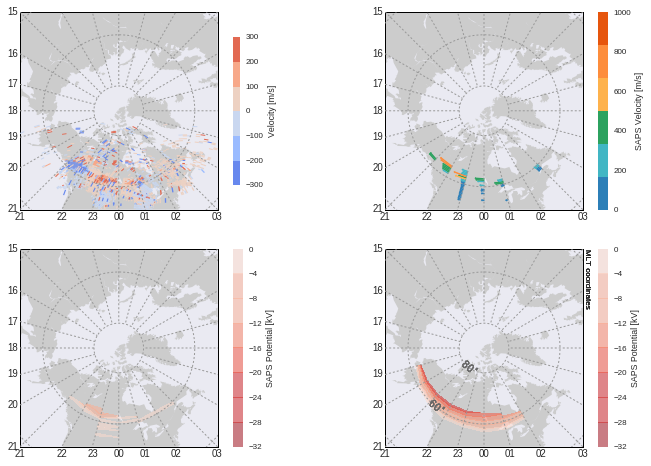

In [15]:
# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
velSeaMap = ListedColormap( sns.color_palette("coolwarm") )
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
velMagnSeaMap = ListedColormap(sns.color_palette(colors))
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))

# pltDF = predPotDF[ ["Lat", "normMLT",\
#                         "potential"] ].pivot( "Lat", "normMLT" )

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Plot data on the first axis
# Plot data on the first axis
# m1 = utils.plotUtils.mapObj( coords=coords,\
#                            lat_0=70., lon_0=-45, width=66e3*120,\
#                            height=111e3*55, datetime=sapsTime, ax=ax1)
m1 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax1, lat_0=90.,\
                            lon_0=0., datetime=sapsTime)
obj = sd_scan_muh.sdvel_on_map(m1, ax1, sapsRadList, sapsTime)
colNorm = Normalize( vmin=velScale[0], vmax=velScale[1] )
obj.overlay_raw_data(param="velocity", gsct=1,\
                     fill=True, vel_lim=velScale,\
                     zorder=8, cmap=velSeaMap, norm=colNorm, alpha=1.)
# ssObj.overlay_sat_data( fDict, m1, ax1, satList=["F18"],\
#          inpTime=ssusiTime, vmin=0., vmax=2000., zorder=7,\
#             autoScale=False, coords=coords,alpha=0.3,\
#             cbar_shrink=0.75, titleString=sapsTime.strftime("%Y%m%d-%H%M") + " UT" )
# poesPltObj = poes_plot_utils.PlotUtils(eventDate, pltCoords=coords)
# poesPltObj.overlay_closest_sat_pass(sapsTime,m1,ax1,poesRawDir)
# # two ways to overlay estimated boundary!
# # poesPltObj.overlay_equ_bnd(selTime,m,ax,rawSatDir="/tmp/poes/raw/")
# poesPltObj.overlay_equ_bnd(selTime,m1,ax1,\
#                 inpFileName=poesBndDir + "poes-fit-" + eventDate.strftime("%Y%m%d") + ".txt")
cax = plt.colorbar(obj.losvel_mappable,ax=ax1,cmap=velSeaMap,\
             orientation='vertical', shrink=0.75)
cax.set_label('Velocity [m/s]')
# Plot data on the first axis
# Plot data on the first axis

# Plot data on the second axis
# Plot data on the second axis
m2 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax2, lat_0=90.,\
                            lon_0=0., datetime=mapTime)

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMlonend, currMLATend, currMlonbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = velMagnSeaMap( colNorm(currVel) )
        currXVecBgn, currYVecBgn = m2(currMlonbgn*15, currMLATbgn, coords=pltCoords)
        currXVecEnd, currYVecEnd = m2(currMlonend*15, currMLATend, coords=pltCoords)
        velPlot = ax2.plot( [currXVecBgn, currXVecEnd], [ currYVecBgn, currYVecEnd ], color=currCol )     
        ax2.arrow( currXVecBgn, currYVecBgn, currXVecEnd-currXVecBgn, currYVecEnd-currYVecBgn,\
                 head_width=1e5, head_length=5e4, fc=currCol, ec=currCol)
        
sm = plt.cm.ScalarMappable(cmap=velMagnSeaMap,\
                    norm=Normalize(vmin=velMagnScale[0],\
                    vmax=velMagnScale[1]))
sm._A = []
plt.colorbar(sm, ax=ax2)
sm.colorbar.ax.set_ylabel('SAPS Velocity [m/s]')        
# Plot data on the second axis
# Plot data on the second axis

# Plot data on the third axis
# Plot data on the third axis
seaMap = ListedColormap(sns.color_palette("Reds_r"))
m3 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax3, lat_0=90.,\
                            lon_0=0., datetime=sapsTime)
pltDF = potentialDF[ ["mlat", "normMlt",\
                        "potential"] ].pivot( "mlat", "normMlt" )
mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x+24. if x < 0. else x for x in nrmMltsPot ]
potVals=pltDF.values
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
xVec, yVec = m3(mltsPotCntr*15., mlatsPotCntr, coords=pltCoords)
cntrPlt = m3.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 8., alpha=0.5,\
    cmap=seaMap, ax=ax3);
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels,ax=ax3)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('SAPS Potential [kV]')
# Plot data on the third axis
# Plot data on the third axis

# Plot data on the fourth axis
# Plot data on the fourth axis
pltDF = predPotDF[ ["Lat", "normMLT",\
                        "potential"] ].pivot( "Lat", "normMLT" )

mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x+24. if x < 0. else x for x in nrmMltsPot ]
mlonPots = convert_mlt( mltsPot, vecsTime , m2a=True )
potVals=pltDF.values
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
m4 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax4, lat_0=90.,\
                            lon_0=0., datetime=mapTime)

xVec, yVec = m4(mltsPotCntr*15., mlatsPotCntr, coords=pltCoords)
cntrPlt = m4.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 8., alpha=0.5,\
    cmap=seaMap, ax=ax4);
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels,ax=ax4)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('SAPS Potential [kV]')
# Plot data on the fourth axis
# Plot data on the fourth axis


fig.savefig("../figs/model-obs-cmpr" + eventDate.strftime("%Y%m%d") + ".eps",bbox_inches='tight')

In [16]:
print predPotDF["potential"].min(), predPotDF["potential"].mean(), predPotDF["potential"].median()
print "---------------------------------------------------"
print potentialDF["potential"].min(), potentialDF["potential"].mean(), potentialDF["potential"].median()

-22.77388987858924 -10.378571046865547 -9.43746781466
---------------------------------------------------
-11.95 -3.1578846153846154 -2.155
